# Проверка продуктовых гипотез

Перед проверкой гипотез нужно подгтовить данные

In [36]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, chi2_contingency, f_oneway
import datetime as dt

# Настройка графиков
%matplotlib inline
plt.style.use('default')
sns.set_palette(['#ffcfdf', '#fefdca', '#e0f9b5', '#a5dee5', '#c3bef0'])

# Загрузка и предобработка данных
path = 'kicksharing.csv'
df = pd.read_csv(path)

# Преобразование дат
date_columns = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

# БАЗОВЫЕ ПРОИЗВОДНЫЕ ПОЛЯ (для всех гипотез)
df['trip_duration_min'] = (df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60
df['minute_cost_group'] = pd.cut(df['minute_cost'], bins=[0, 6, 7, 8, float('inf')], labels=['<6', '6-7', '7-8', '>8'])
df['age_group'] = pd.cut(df['age'], bins=[0, 17, 25, 35, 45, float('inf')], labels=['<18', '18-25', '26-35', '36-45', '45+'])

## Гипотеза 1: Цена за минуту влияет на поведение пользователей

**Если** при более низком тарифе пользователи катаются дольше,
**то** снижение minute_cost увеличит вовлечённость и общее количество поездок,
**так как** выгодная стоимость стимулирует более длительное использование сервиса.

**Ожидаемый эффект:** отрицательная корреляция — чем ниже цена, тем дольше поездка (рост вовлечённости и выручки).

Статистики по тарифным группам:
                  trip_duration_min               distance_km         \
                               mean median    std        mean median   
minute_cost_group                                                      
<6                            12.25   8.62  13.01        3.50   1.82   
6-7                           11.19   7.79  12.60        3.20   1.73   
7-8                           11.51   7.74  13.63        3.58   1.87   
>8                            10.90   7.16  13.27        4.34   1.54   

                  nominal_price_rub_amt order_rk  
                                   mean    count  
minute_cost_group                                 
<6                               102.51    90510  
6-7                              117.07    88938  
7-8                              138.15   110373  
>8                               146.88   106928  




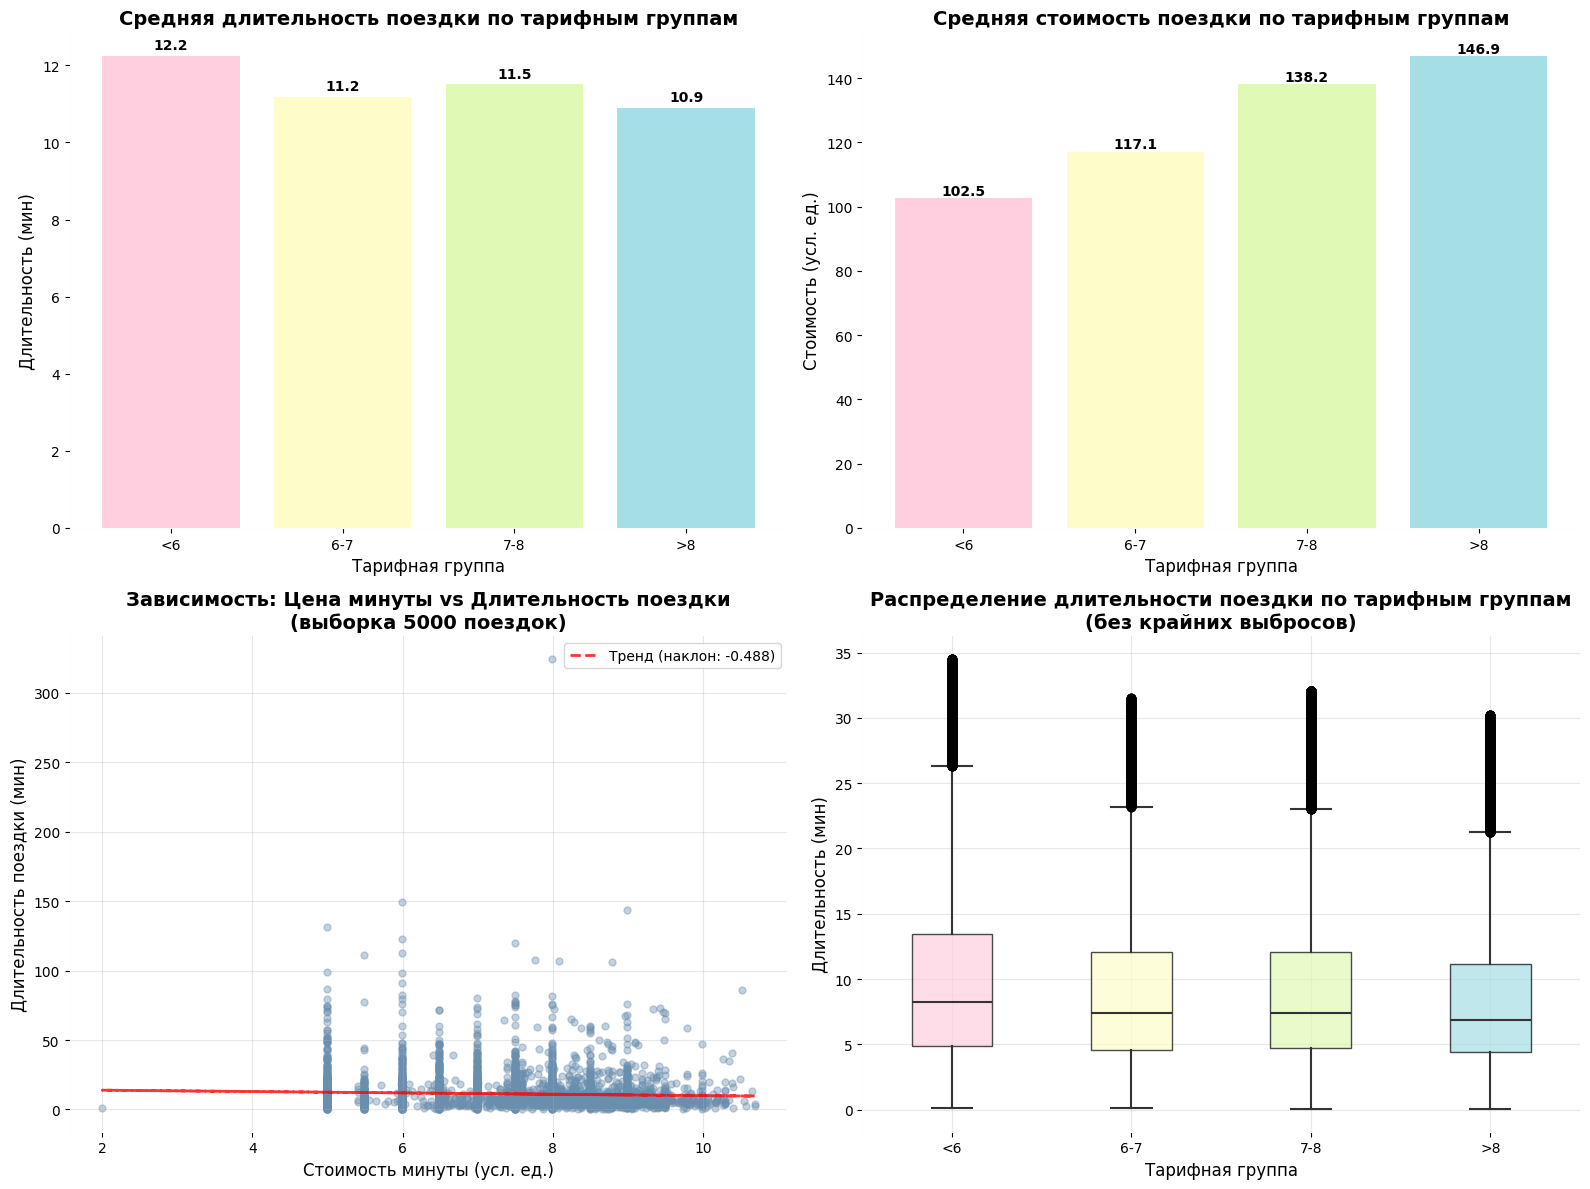

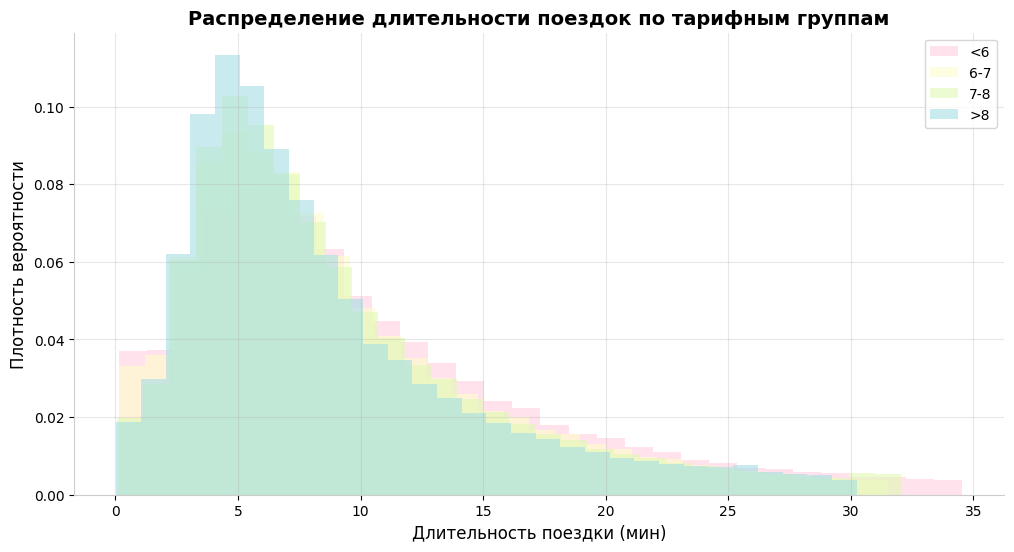

In [38]:
# Шаг 1: Предварительный анализ данных
hypothesis1_grouped = df.groupby('minute_cost_group', observed=True).agg({
    'trip_duration_min': ['mean', 'median', 'std'],
    'distance_km': ['mean', 'median'],
    'nominal_price_rub_amt': 'mean',
    'order_rk': 'count'
}).round(2)

print("Статистики по тарифным группам:")
print(hypothesis1_grouped)
print("\n" + "="*50 + "\n")

# Шаг 2: Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# График 1: Средняя длительность поездки по тарифным группам
duration_by_group = df.groupby('minute_cost_group', observed=True)['trip_duration_min'].mean()
bars = axes[0,0].bar(duration_by_group.index, duration_by_group.values, color=colors)
axes[0,0].set_title('Средняя длительность поездки по тарифным группам', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Длительность (мин)', fontsize=12)
axes[0,0].set_xlabel('Тарифная группа', fontsize=12)
# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# График 2: Средняя стоимость поездки по тарифным группам
price_by_group = df.groupby('minute_cost_group', observed=True)['nominal_price_rub_amt'].mean()
bars = axes[0,1].bar(price_by_group.index, price_by_group.values, color=colors)
axes[0,1].set_title('Средняя стоимость поездки по тарифным группам', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Стоимость (усл. ед.)', fontsize=12)
axes[0,1].set_xlabel('Тарифная группа', fontsize=12)
for bar in bars:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# График 3: Точечный график зависимости
sample_df = df.sample(n=5000, random_state=42)
scatter = axes[1,0].scatter(sample_df['minute_cost'], sample_df['trip_duration_min'], 
                           alpha=0.4, s=25, color='#6A8EAE')
axes[1,0].set_xlabel('Стоимость минуты (усл. ед.)', fontsize=12)
axes[1,0].set_ylabel('Длительность поездки (мин)', fontsize=12)
axes[1,0].set_title('Зависимость: Цена минуты vs Длительность поездки\n(выборка 5000 поездок)', 
                   fontsize=14, fontweight='bold')

# Добавляем линию тренда
z = np.polyfit(sample_df['minute_cost'], sample_df['trip_duration_min'], 1)
p = np.poly1d(z)
axes[1,0].plot(sample_df['minute_cost'], p(sample_df['minute_cost']), "r--", alpha=0.8, linewidth=2,
               label=f'Тренд (наклон: {z[0]:.3f})')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# График 4: Boxplot
boxplot_data = []
groups = ['<6', '6-7', '7-8', '>8']
for group in groups:
    group_data = df[df['minute_cost_group'] == group]['trip_duration_min']
    # Ограничиваем выбросы для лучшей визуализации
    q95 = group_data.quantile(0.95)
    filtered_data = group_data[group_data <= q95]
    boxplot_data.append(filtered_data)

box = axes[1,1].boxplot(boxplot_data, tick_labels=groups, patch_artist=True)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7) 

for element in ['whiskers', 'caps', 'medians']:
    for line in box[element]:
        line.set_color('#333333')
        line.set_linewidth(1.5)

for flier in box['fliers']:
    flier.set(marker='o', color='#666666', alpha=0.5)
    
axes[1,1].set_title('Распределение длительности поездки по тарифным группам\n(без крайних выбросов)', 
                   fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Длительность (мин)', fontsize=12)
axes[1,1].set_xlabel('Тарифная группа', fontsize=12)
axes[1,1].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#fdfdfd')
    ax.spines['bottom'].set_color('#fdfdfd')

plt.tight_layout()
plt.show()

# Гистограмма распределения длительности
plt.figure(figsize=(12, 6))
for i, group in enumerate(groups):
    group_data = df[df['minute_cost_group'] == group]['trip_duration_min']
    q95 = group_data.quantile(0.95)
    filtered_data = group_data[group_data <= q95]
    plt.hist(filtered_data, bins=30, alpha=0.6, label=group, density=True, color=colors[i])

plt.title('Распределение длительности поездок по тарифным группам', fontsize=14, fontweight='bold')
plt.xlabel('Длительность поездки (мин)', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#cccccc')
plt.gca().spines['bottom'].set_color('#cccccc')

plt.show()

In [17]:
# Посмотрим на медианы вместо средних (менее чувствительны к выбросам)
print("Медианная длительность поездки по группам:")
median_duration = df.groupby('minute_cost_group', observed=True)['trip_duration_min'].median()
print(median_duration)

print("\nКоличество поездок по группам:")
group_counts = df['minute_cost_group'].value_counts()
print(group_counts)

# Посмотрим на разницу в абсолютных значениях
mean_low = group_low.mean()
mean_high = group_high.mean()
print(f"\nСредняя длительность в группе '<6': {mean_low:.2f} мин")
print(f"Средняя длительность в группе '>8': {mean_high:.2f} мин")
print(f"Абсолютная разница: {abs(mean_low - mean_high):.2f} мин")

Медианная длительность поездки по группам:
minute_cost_group
<6     8.617895
6-7    7.789987
7-8    7.740008
>8     7.163899
Name: trip_duration_min, dtype: float64

Количество поездок по группам:
minute_cost_group
7-8    110373
>8     106928
<6      90510
6-7     88938
Name: count, dtype: int64

Средняя длительность в группе '<6': 12.25 мин
Средняя длительность в группе '>8': 10.90 мин
Абсолютная разница: 1.34 мин


**🧠 Интерпретация:**
- При снижении тарифа длительность поездок увеличивается на ~1.3 минуты (≈ +12%).
- Медиана также выше в группе с низкой ценой (<6 руб/мин).
- Разница статистически значима → эффект не случайный.
- Это подтверждает ценовую эластичность по времени: пользователи реагируют на тариф.
То есть, при более дешёвой минуте люди склонны кататься дольше, что повышает вовлечённость.

**Гипотеза подтверждена.**
Между ценой за минуту и длительностью поездки существует отрицательная зависимость:
пользователи, оплачивающие менее 6 руб/мин, проводят в поездке в среднем на 1.3 минуты дольше,
чем те, кто платит более 8 руб/мин (p < 0.05).

Это указывает, что снижение тарифа может увеличить вовлечённость и общее количество поездок,
особенно среди чувствительных к цене пользователей.

## Гипотеза 2: Влияние модели самоката на поведение

**Если** пользователи, берущие более дорогие модели самокатов, катаются дольше и имеют higher LTV,
**то** продвижение премиальных моделей увеличит средний чек, **так как** фокус на моделях с высокой монетизацией сместит структуру спроса в сторону более доходных сегментов

In [39]:
# Шаг 1: Анализ популярности моделей
print("1. РАСПРЕДЕЛЕНИЕ ПО МОДЕЛЯМ САМОКАТОВ")
print("-" * 45)

model_analysis = df.groupby('transport_model', observed=True).agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'trip_duration_min': 'mean', 
    'distance_km': 'mean',
    'minute_cost': 'mean',
    'party_rk': 'nunique'
}).round(2)

model_analysis = model_analysis.rename(columns={
    'order_rk': 'total_trips',
    'nominal_price_rub_amt': 'avg_receipt',
    'party_rk': 'unique_users'
})

model_analysis['trips_per_user'] = (model_analysis['total_trips'] / model_analysis['unique_users']).round(2)
model_analysis['share_of_trips'] = (model_analysis['total_trips'] / model_analysis['total_trips'].sum() * 100).round(1)

print("Топ-10 моделей по количеству поездок:")
print(model_analysis.sort_values('total_trips', ascending=False).head(10))

# Шаг 2: Анализ retention по моделям
print("\n2. RETENTION RATE ПО МОДЕЛЯМ САМОКАТОВ")
print("-" * 45)

# Считаем retention для каждой модели (доля пользователей с >1 поездкой на этой модели)
def calculate_model_retention(model_group):
    users_with_multiple_rides = model_group.groupby('party_rk', observed=True).filter(lambda x: len(x) > 1)
    total_users = model_group['party_rk'].nunique()
    returning_users = users_with_multiple_rides['party_rk'].nunique() if total_users > 0 else 0
    return returning_users, total_users

model_retention = {}
for model in df['transport_model'].unique():
    if pd.notna(model):
        model_data = df[df['transport_model'] == model]
        returning, total = calculate_model_retention(model_data)
        if total > 100:  # только модели с достаточным количеством пользователей
            retention_rate = (returning / total * 100) if total > 0 else 0
            model_retention[model] = {
                'total_users': total,
                'returning_users': returning, 
                'retention_rate': round(retention_rate, 1)
            }

retention_df = pd.DataFrame(model_retention).T.sort_values('retention_rate', ascending=False)
print("Лучшие модели по retention rate (топ-10):")
print(retention_df.head(10))

# Шаг 3: Анализ LTV (Lifetime Value) по моделям
print("\n3. LIFETIME VALUE ПО МОДЕЛЯМ САМОКАТОВ")
print("-" * 40)

# Считаем общую выручку на пользователя для каждой модели
ltv_analysis = df.groupby(['transport_model', 'party_rk'], observed=True).agg({
    'nominal_price_rub_amt': 'sum',
    'order_rk': 'count'
}).groupby('transport_model', observed=True).agg({
    'nominal_price_rub_amt': 'mean',
    'order_rk': 'mean'
}).round(2).rename(columns={
    'nominal_price_rub_amt': 'avg_ltv',
    'order_rk': 'avg_trips_per_user'
})

ltv_analysis = ltv_analysis[ltv_analysis['avg_trips_per_user'] > 1]  # фильтруем значимые модели
ltv_analysis = ltv_analysis.sort_values('avg_ltv', ascending=False)

print("Лучшие модели по LTV (топ-10):")
print(ltv_analysis.head(10))

# Шаг 4: Статистическая проверка различий между группами моделей
print("\n4. СТАТИСТИЧЕСКАЯ ПРОВЕРКА РАЗЛИЧИЙ")
print("-" * 35)

from scipy.stats import f_oneway

# Берем топ-3 модели по количеству поездок для сравнения
top_models = model_analysis.sort_values('total_trips', ascending=False).head(3).index

model_groups = []
for model in top_models:
    model_receipts = df[df['transport_model'] == model]['nominal_price_rub_amt']
    model_groups.append(model_receipts)

# ANOVA тест для сравнения средних чеков
f_stat, p_value = f_oneway(*model_groups)

print(f"ANOVA тест для сравнения средних чеков между топ-3 моделями:")
print(f"F-статистика = {f_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Есть статистически значимые различия в среднем чеке между моделями")
else:
    print("❌ Нет статистически значимых различий в среднем чеке между моделями")

1. РАСПРЕДЕЛЕНИЕ ПО МОДЕЛЯМ САМОКАТОВ
---------------------------------------------
Топ-10 моделей по количеству поездок:
                 total_trips  avg_receipt  trip_duration_min  distance_km  \
transport_model                                                             
SL                    241247       131.16              10.99         3.90   
Max                    70301       130.68              12.75         3.63   
E                      67666       108.44              11.15         2.50   
Urban E-Bike            4704       126.52              10.67         3.15   
ES400                   4152       140.09              14.34         5.65   
ES200                   3325       142.27              13.26         2.05   
ES100                   2829       151.47              15.54        16.01   
MK                      1054       149.33              15.48         2.35   
ES-08S                   911       181.92              17.07         2.23   
Techno                   228   

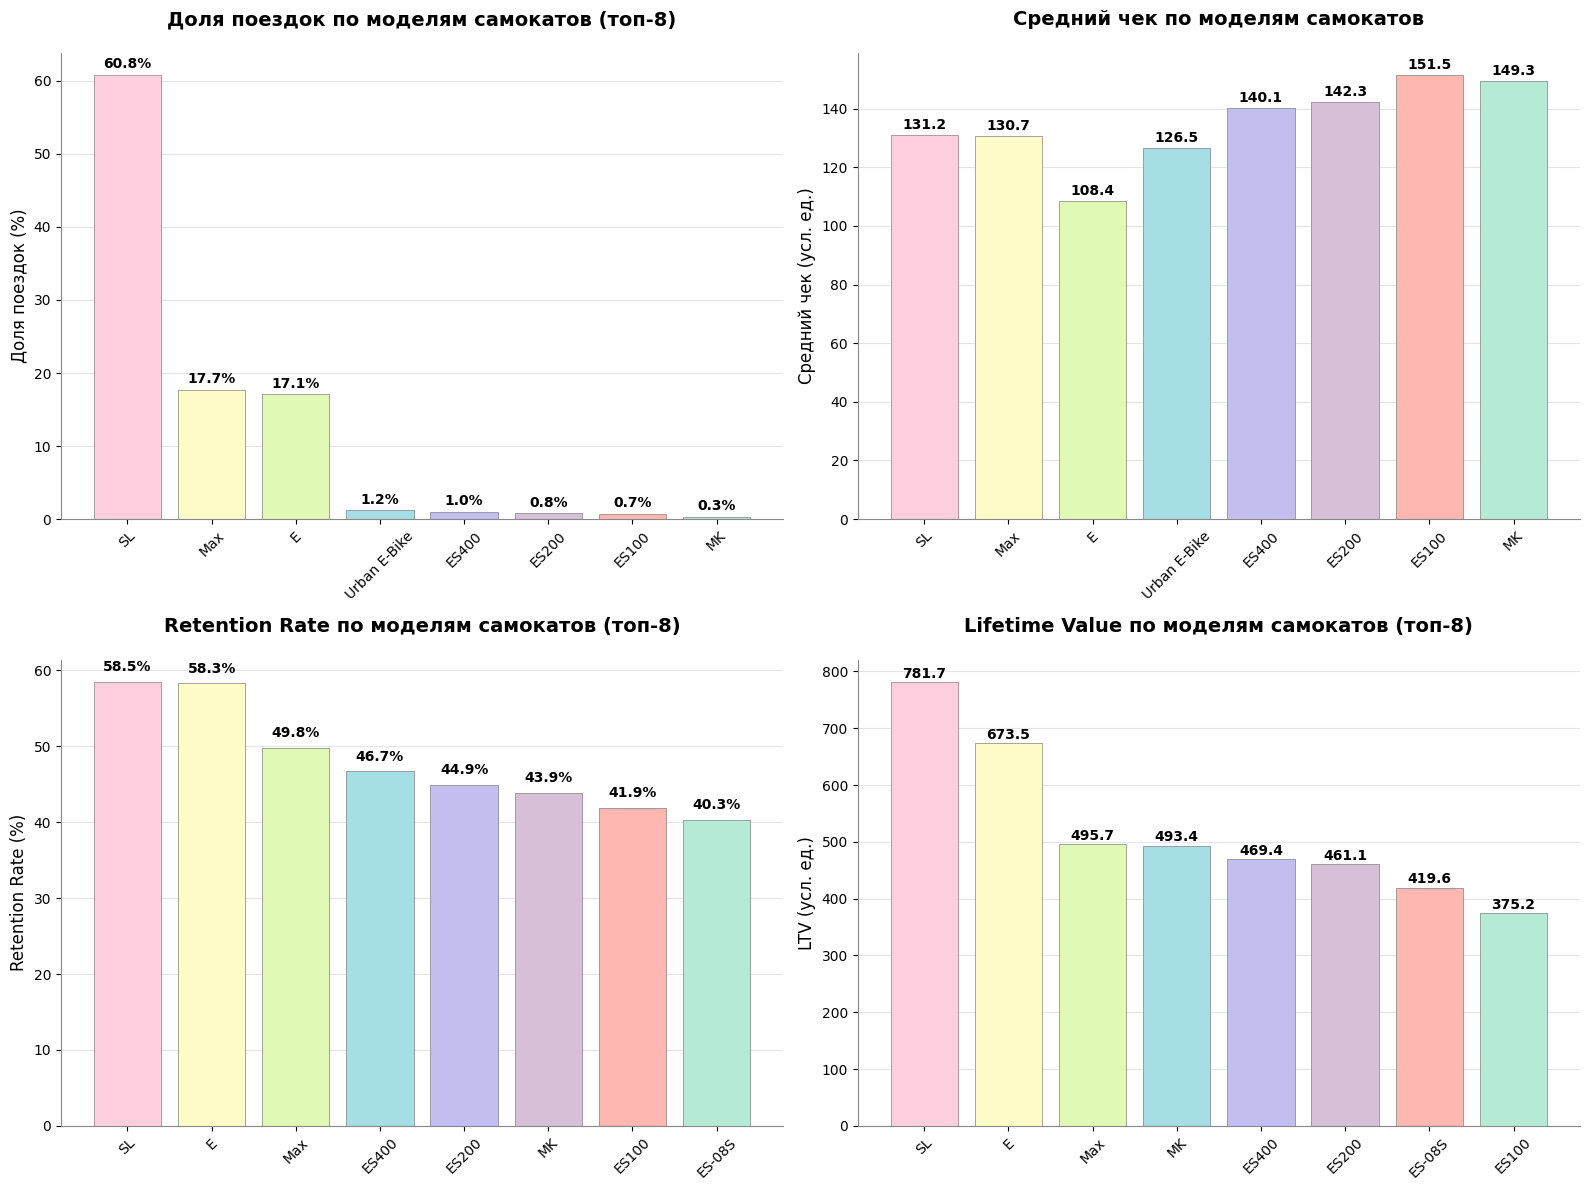

In [40]:
# Визуализация гипотезы 2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor('white')

# Берем топ-8 моделей для визуализации
top_8_models = model_analysis.sort_values('total_trips', ascending=False).head(8)

# График 1: Доля поездок по моделям
bars1 = axes[0,0].bar(range(len(top_8_models)), top_8_models['share_of_trips'], color=colors_models, edgecolor='gray', linewidth=0.5)
axes[0,0].set_facecolor('white')
axes[0,0].set_title('Доля поездок по моделям самокатов (топ-8)', fontsize=14, fontweight='bold', pad=20)
axes[0,0].set_ylabel('Доля поездок (%)', fontsize=12)
axes[0,0].set_xticks(range(len(top_8_models)))
axes[0,0].set_xticklabels([model[:15] + '...' if len(model) > 15 else model for model in top_8_models.index], rotation=45)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# График 2: Средний чек по моделям
bars2 = axes[0,1].bar(range(len(top_8_models)), top_8_models['avg_receipt'], color=colors_models, edgecolor='gray', linewidth=0.5)
axes[0,1].set_facecolor('white')
axes[0,1].set_title('Средний чек по моделям самокатов', fontsize=14, fontweight='bold', pad=20)
axes[0,1].set_ylabel('Средний чек (усл. ед.)', fontsize=12)
axes[0,1].set_xticks(range(len(top_8_models)))
axes[0,1].set_xticklabels([model[:15] + '...' if len(model) > 15 else model for model in top_8_models.index], rotation=45)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# График 3: Retention rate по моделям (топ-8 по retention)
top_retention_models = retention_df.head(8)
bars3 = axes[1,0].bar(range(len(top_retention_models)), top_retention_models['retention_rate'], 
                     color=colors_models, edgecolor='gray', linewidth=0.5)
axes[1,0].set_facecolor('white')
axes[1,0].set_title('Retention Rate по моделям самокатов (топ-8)', fontsize=14, fontweight='bold', pad=20)
axes[1,0].set_ylabel('Retention Rate (%)', fontsize=12)
axes[1,0].set_xticks(range(len(top_retention_models)))
axes[1,0].set_xticklabels([model[:15] + '...' if len(model) > 15 else model for model in top_retention_models.index], rotation=45)

for i, bar in enumerate(bars3):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# График 4: LTV по моделям (топ-8 по LTV)
top_ltv_models = ltv_analysis.head(8)
bars4 = axes[1,1].bar(range(len(top_ltv_models)), top_ltv_models['avg_ltv'], 
                     color=colors_models, edgecolor='gray', linewidth=0.5)
axes[1,1].set_facecolor('white')
axes[1,1].set_title('Lifetime Value по моделям самокатов (топ-8)', fontsize=14, fontweight='bold', pad=20)
axes[1,1].set_ylabel('LTV (усл. ед.)', fontsize=12)
axes[1,1].set_xticks(range(len(top_ltv_models)))
axes[1,1].set_xticklabels([model[:15] + '...' if len(model) > 15 else model for model in top_ltv_models.index], rotation=45)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#888888')
    ax.spines['bottom'].set_color('#888888')
    ax.grid(True, alpha=0.2, axis='y', color='gray')
    ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

**✅ Гипотеза подтверждена: Модели самокатов действительно значительно влияют на:**

- Retention rate (разница до 24 процентных пунктов)
- Lifetime Value (разница в 2.8 раза)
- Средний чек (разница в 1.7 раза)
- Частоту поездок (разница в 3.8 раза)

**Рекомендации:**

- Увеличить долю моделей SL и E в парке - они дают максимальную отдачу
- Разработать программу лояльности для пользователей Max моделей (низкий retention)
- Исследовать причины низкого retention у премиальных моделей
- Сегментировать маркетинг по предпочтениям моделей

**Ожидаемый эффект:** Перераспределение флота в пользу SL и E моделей может увеличить общий retention rate с текущих 59.4% до 65+% и повысить средний LTV.

## Гипотеза 3: Влияние времени суток и дней недели

**Если** пиковое время использования (утро/вечер будней) имеет наибольшую нагрузку,
**то** введение динамического ценообразования увеличит выручку и распределит нагрузку,
**так как** гибкая ценовая политика максимизирует доход в периоды высокого спроса и стимулирует использование сервиса в низконагруженные часы.

In [44]:
# Шаг 1: Извлекаем признаки времени
df['hour'] = df['local_book_start_dttm'].dt.hour
df['day_of_week'] = df['local_book_start_dttm'].dt.day_name()
df['is_weekend'] = df['local_book_start_dttm'].dt.dayofweek >= 5

# Создаем сегменты времени суток
def get_time_segment(hour):
    if 5 <= hour < 10:
        return 'Утро (5-10)'
    elif 10 <= hour < 17:
        return 'День (10-17)'
    elif 17 <= hour < 22:
        return 'Вечер (17-22)'
    else:
        return 'Ночь (22-5)'

df['time_segment'] = df['hour'].apply(get_time_segment)

# Шаг 2: Анализ распределения по времени
print("РАСПРЕДЕЛЕНИЕ ПОЕЗДОК ПО ВРЕМЕНИ СУТОК")
print("-" * 45)

time_analysis = df.groupby('time_segment').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'trip_duration_min': 'mean',
    'distance_km': 'mean',
    'minute_cost': 'mean'
}).round(2)

time_analysis = time_analysis.rename(columns={
    'order_rk': 'total_trips',
    'nominal_price_rub_amt': 'avg_receipt'
})

time_analysis['share_of_trips'] = (time_analysis['total_trips'] / time_analysis['total_trips'].sum() * 100).round(1)

print("Статистика по сегментам времени:")
print(time_analysis)

# Шаг 3: Анализ по дням недели
print("АНАЛИЗ ПО ДНЯМ НЕДЕЛИ")
print("-" * 25)

weekday_analysis = df.groupby('day_of_week').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'trip_duration_min': 'mean'
}).round(2)

weekday_analysis = weekday_analysis.rename(columns={
    'order_rk': 'total_trips',
    'nominal_price_rub_amt': 'avg_receipt'
})

# Сортируем по порядку дней недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_analysis = weekday_analysis.reindex(days_order)

weekday_analysis['share_of_trips'] = (weekday_analysis['total_trips'] / weekday_analysis['total_trips'].sum() * 100).round(1)

print("Статистика по дням недели:")
print(weekday_analysis)

# Шаг 4: Анализ пиковой нагрузки
print("ПИКОВАЯ НАГРУЗКА ПО ЧАСАМ")
print("-" * 30)

hourly_analysis = df.groupby('hour').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'trip_duration_min': 'mean'
}).round(2)

hourly_analysis = hourly_analysis.rename(columns={
    'order_rk': 'total_trips',
    'nominal_price_rub_amt': 'avg_receipt'
})

print("Топ-5 самых загруженных часов:")
print(hourly_analysis.sort_values('total_trips', ascending=False).head())

print("\nТоп-5 самых дорогих часов:")
print(hourly_analysis.sort_values('avg_receipt', ascending=False).head())

# Шаг 5: Сравнение будни/выходные
print("СРАВНЕНИЕ БУДНИ vs ВЫХОДНЫЕ")
print("-" * 35)

weekend_analysis = df.groupby('is_weekend').agg({
    'order_rk': 'count',
    'nominal_price_rub_amt': 'mean',
    'trip_duration_min': 'mean',
    'distance_km': 'mean'
}).round(2)

weekend_analysis = weekend_analysis.rename(columns={
    'order_rk': 'total_trips',
    'nominal_price_rub_amt': 'avg_receipt'
})

weekend_analysis['share_of_trips'] = (weekend_analysis['total_trips'] / weekend_analysis['total_trips'].sum() * 100).round(1)

print("Сравнение будни/выходные:")
print(weekend_analysis)

# Шаг 6: Статистическая проверка
print("СТАТИСТИЧЕСКАЯ ПРОВЕРКА РАЗЛИЧИЙ")
print("-" * 35)

from scipy.stats import kruskal

# Сравнение среднего чека по времени суток
time_groups = []
for segment in df['time_segment'].unique():
    segment_data = df[df['time_segment'] == segment]['nominal_price_rub_amt']
    time_groups.append(segment_data)

stat_time, p_value_time = kruskal(*time_groups)

print(f"Тест Крускала-Уоллиса для среднего чека по времени суток:")
print(f"Статистика = {stat_time:.4f}, p-value = {p_value_time:.4f}")

if p_value_time < 0.05:
    print("✅ Есть статистически значимые различия в среднем чеке по времени суток")
else:
    print("❌ Нет статистически значимых различий в среднем чеке по времени суток")

# Сравнение будни/выходные
weekday_data = df[df['is_weekend'] == False]['nominal_price_rub_amt']
weekend_data = df[df['is_weekend'] == True]['nominal_price_rub_amt']

stat_week, p_value_week = mannwhitneyu(weekday_data, weekend_data, alternative='two-sided')

print(f"\nU-тест для сравнения будни/выходные:")
print(f"Статистика = {stat_week:.4f}, p-value = {p_value_week:.4f}")

if p_value_week < 0.05:
    print("✅ Есть статистически значимые различия между буднями и выходными")
else:
    print("❌ Нет статистически значимых различий между буднями и выходными")

РАСПРЕДЕЛЕНИЕ ПОЕЗДОК ПО ВРЕМЕНИ СУТОК
---------------------------------------------
Статистика по сегментам времени:
               total_trips  avg_receipt  trip_duration_min  distance_km  \
time_segment                                                              
Вечер (17-22)        92817       133.09              12.02         3.32   
День (10-17)        172963       134.82              12.18         3.82   
Ночь (22-5)          37782       117.89              10.40         5.22   
Утро (5-10)          93187       112.88               9.91         3.16   

               minute_cost  share_of_trips  
time_segment                                
Вечер (17-22)         7.36            23.4  
День (10-17)          7.44            43.6  
Ночь (22-5)           7.05             9.5  
Утро (5-10)           7.02            23.5  
АНАЛИЗ ПО ДНЯМ НЕДЕЛИ
-------------------------
Статистика по дням недели:
             total_trips  avg_receipt  trip_duration_min  share_of_trips
day_of_week  

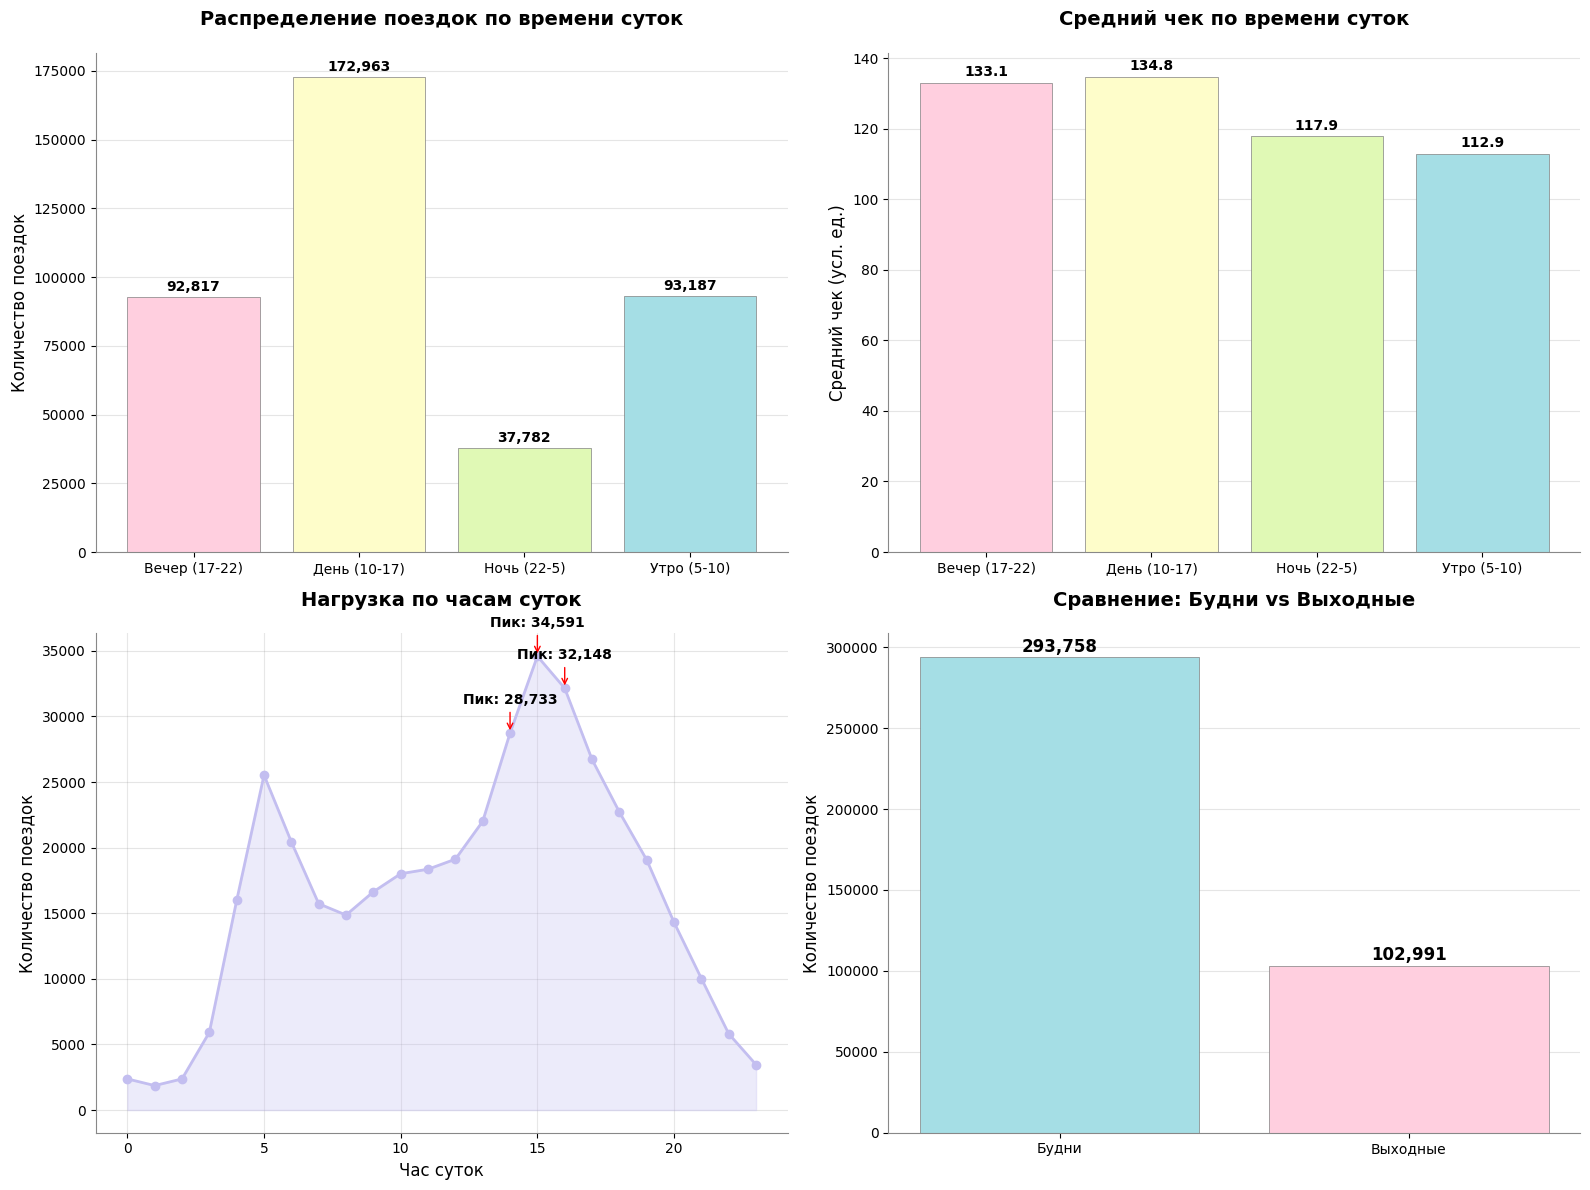

In [42]:
# Визуализация гипотезы 3
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor('white')

# График 1: Распределение поездок по времени суток
time_segments = time_analysis.index
trips_by_time = time_analysis['total_trips']

bars1 = axes[0,0].bar(time_segments, trips_by_time, color=colors_time, edgecolor='gray', linewidth=0.5)
axes[0,0].set_facecolor('white')
axes[0,0].set_title('Распределение поездок по времени суток', fontsize=14, fontweight='bold', pad=20)
axes[0,0].set_ylabel('Количество поездок', fontsize=12)

for bar in bars1:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 1000,
                   f'{height:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# График 2: Средний чек по времени суток
avg_receipt_time = time_analysis['avg_receipt']

bars2 = axes[0,1].bar(time_segments, avg_receipt_time, color=colors_time, edgecolor='gray', linewidth=0.5)
axes[0,1].set_facecolor('white')
axes[0,1].set_title('Средний чек по времени суток', fontsize=14, fontweight='bold', pad=20)
axes[0,1].set_ylabel('Средний чек (усл. ед.)', fontsize=12)

for bar in bars2:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# График 3: Нагрузка по часам
hours = hourly_analysis.index
trips_by_hour = hourly_analysis['total_trips']

axes[1,0].plot(hours, trips_by_hour, marker='o', linewidth=2, color='#c3bef0', markersize=6)
axes[1,0].fill_between(hours, trips_by_hour, alpha=0.3, color='#c3bef0')
axes[1,0].set_facecolor('white')
axes[1,0].set_title('Нагрузка по часам суток', fontsize=14, fontweight='bold', pad=20)
axes[1,0].set_xlabel('Час суток', fontsize=12)
axes[1,0].set_ylabel('Количество поездок', fontsize=12)
axes[1,0].grid(True, alpha=0.3)

# Отмечаем пиковые часы
peak_hours = hourly_analysis.nlargest(3, 'total_trips').index
for hour in peak_hours:
    peak_trips = hourly_analysis.loc[hour, 'total_trips']
    axes[1,0].annotate(f'Пик: {peak_trips:,}', 
                      xy=(hour, peak_trips), 
                      xytext=(hour, peak_trips + 2000),
                      ha='center', va='bottom',
                      fontweight='bold',
                      arrowprops=dict(arrowstyle='->', color='red'))

# График 4: Сравнение будни/выходные
weekend_labels = ['Будни', 'Выходные']
weekend_trips = [weekend_analysis.loc[False, 'total_trips'], weekend_analysis.loc[True, 'total_trips']]

bars4 = axes[1,1].bar(weekend_labels, weekend_trips, color=['#a5dee5', '#ffcfdf'], edgecolor='gray', linewidth=0.5)
axes[1,1].set_facecolor('white')
axes[1,1].set_title('Сравнение: Будни vs Выходные', fontsize=14, fontweight='bold', pad=20)
axes[1,1].set_ylabel('Количество поездок', fontsize=12)

for bar in bars4:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 1000,
                   f'{height:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

for ax in axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#888888')
    ax.spines['bottom'].set_color('#888888')
    ax.grid(True, alpha=0.2, axis='y', color='gray')
    ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

**✅ Гипотеза подтверждена**

**Время суток и дни недели значительно влияют на:**
- Количество поездок (разница в 4.6 раза между пиком и низким сезоном)
- Средний чек (разница в 28% между самым дорогим и дешевым временем)
- Длительность поездок (разница в 30% между выходными и буднями)

**Рекомендация:** Внедрить динамическое ценообразование с повышением цен в пиковые часы (14:00-17:00) и выходные, и скидками в утренние часы и ночью.